In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import classifier_utils as utils

In [6]:
import cv2

# Get Dataset

In [4]:
# Dataset
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]
train, test = utils.get_augmented_dataset(categories)

Dropped 2082 patches because too close to image border


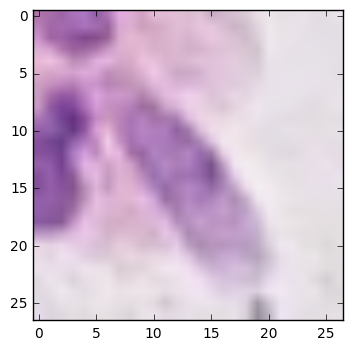

In [8]:
plt.imshow(train['patches'][0])

# Get HOG Features

In [13]:
def get_hog_features(hog, patches):
    N = patches.shape[0]
    descriptor_size = hog.getDescriptorSize()
    results = np.zeros((N, descriptor_size))
    for (i, patch) in enumerate(patches):
        uint_patch = (patch * 255).astype('uint8')
        resized_patch = cv2.resize(uint_patch, winSize, interpolation=cv2.INTER_LINEAR)
        feature_vector = hog.compute(resized_patch)[:, 0]
        results[i] = feature_vector
    return results

In [14]:
# Compute HOG descriptors for each test/train example

# Specify HOG parameters
winSize = (32, 32)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

# Get training descriptors
train['hog_features'] = get_hog_features(hog, train['patches'])

# Get test descriptors
test['hog_features'] = get_hog_features(hog, test['patches'])

In [15]:
for (k, v) in train.iteritems():
    print "train", k, v.shape
for (k, v) in test.iteritems():
    print "test", k, v.shape

train hog_features (60000, 324)
train hsv_factors (60000, 3)
train deltas (60000, 2)
train patches (60000, 27, 27, 3)
train rots (60000,)
train labels (60000, 4)
train flips (60000,)
train centres (60000, 2)
train img_ids (60000,)
test hog_features (4073, 324)
test img_ids (4073,)
test labels (4073, 4)
test patches (4073, 27, 27, 3)
test centres (4073, 2)


# SVM Implementation

In [26]:
# gradient of y wrt w given x, activations, and C
# There are M training examples and N features (including bias)
# x is MxN
# y is Mx1
# w is Nx1
# activations is Mx1
# C is scalar
# Returns Nx1 column of gradients
def get_gradient(x, y, w, activations, C):
    values = -1 * x * y # MxN
    mask = (activations[:, 0] == 0.0)
    values[mask, :] = 0
    avg = np.mean(values, axis=0, keepdims=True)
    return C*avg.T + w

# x is MxN
# y is Mx1
# w is Nx1
# Returns Mx1 column of activations
def get_activations(x, y, w):
    #print "x", x.shape
    #print "y", y.shape
    #print "w", w.shape
    return np.maximum(0, 1 - (y * np.matmul(x, w)))

# w is Nx1
# activations is Mx1
# C is scalar
# Returns a scalar
def get_cost(w, activations, C):
    regularizer = 0.5 * np.sum(np.square(w))
    return C * np.mean(activations) + regularizer

# x is MxN
# y is Mx1
# w is Nx1
# C is scalar
# Returns scalar cost and Nx1 column of gradients
def get_cost_and_gradient(x, y, w, C):
    activations = get_activations(x, y, w)
    cost = get_cost(w, activations, C)
    gradient = get_gradient(x, y, w, activations, C)
    return (cost, gradient)

# x is MxN
# y is Mx1
# w is Nx1
# C is scalar
# Returns current cost, new w
def training_step(x, y, w, C, learning_rate):
    (cost, gradient) = get_cost_and_gradient(x, y, w, C)
    step = -1 * learning_rate * gradient
    return (cost, w + step)

def train_loop(x, y, test_x, test_y, C, learning_rate, batch_size, epochs):
    # Lists of stuff, which are global
    global loss, test_loss, params
    loss = []
    test_loss = []
    params = []
    
    (M, N) = x.shape
    assert y.shape == (M, 1)
    (M_test, N_test) = test_x.shape
    assert N_test == N
    assert test_y.shape == (M_test, 1)

    # Intialize weights
    w = np.random.normal(size=(N+1, 1))
    # Add 1s to x for bias term
    x = np.append(x, np.ones((M, 1)), axis=1)
    test_x = np.append(test_x, np.ones((M_test, 1)), axis=1)

    # Run training
    for e in xrange(epochs):
        for i in xrange(0, M, batch_size):
            (cost, w) = training_step(
                x[i:i+batch_size], y[i:i+batch_size], w, C, learning_rate)
            step = i / batch_size
            if step % 50 == 0:
                (test_cost, _) = get_cost_and_gradient(test_x, test_y, w, C)
                print "Epoch %d, step %d, training loss %f, test loss %f" % (
                    e, step, cost, test_cost)
                loss.append(cost)
                test_loss.append(test_cost)
                params.append(w)
        (test_cost, _) = get_cost_and_gradient(test_x, test_y, w, C)
        print "End of epoch %d, training loss %f, test loss %f" % (step, cost, test_cost)

    # Return final params
    return w

def multiclass_train_loop(x, y, test_x, test_y, C, learning_rate, batch_size, epochs):
    global loss, test_loss, params
    global cat_loss, cat_test_loss, cat_params
    cat_loss = []
    cat_test_loss = []
    cat_params = []
    cat_w = []
    
    np.random.seed(31415) # repeatability

    L = y.shape[1]
    (M, N) = x.shape
    assert y.shape == (M, L)
    (M_test, N_test) = test_x.shape
    assert N_test == N
    assert test_y.shape == (M_test, L)

    for label in xrange(L):
        print "Starting label", label
        # Find all positive examples, create +1 labels
        positive_examples = x[y[:, label] == 1, :]
        #print "POSITIVE"
        #print positive_examples
        num_positive_examples = positive_examples.shape[0]
        positive_labels = np.full((num_positive_examples, 1), 1, dtype='int32')

        # Find all negative examples, create -1 labels
        negative_examples = x[y[:, label] != 1, :]
        num_negative_examples = negative_examples.shape[0]
        #assert num_negative_examples >= num_positive_examples
        #print "NEGATIVE"
        #print negative_examples

        # Subsample negative examples
        #sample = np.random.permutation(num_negative_examples)[:num_positive_examples]
        #negative_sample = negative_examples[sample, :]
        #negative_labels = np.full((num_positive_examples, 1), -1, dtype='int32')

        negative_labels = np.full((num_negative_examples, 1), -1, dtype='int32')

        
        # Create shuffled training input to classifier
        all_x = np.vstack([positive_examples, negative_examples])
        all_y = np.vstack([positive_labels, negative_labels])
        shuffle = np.random.permutation(all_x.shape[0])
        all_x = all_x[shuffle]
        all_y = all_y[shuffle]
        #print "TRAIN"
        #print np.hstack([all_x, all_y])

        # Binarize test set labels
        test_labels = np.ones((len(test_y), 1))
        test_labels[test_y[:, label] != 1, :] = -1

        # Run training
        w = train_loop(all_x, all_y, test_x, test_labels, C, learning_rate, batch_size, epochs)

        # Store results for this category
        cat_loss.append(loss)
        cat_test_loss.append(test_loss)
        cat_params.append(params)
        cat_w.append(w)

    # Return per-parameter weights
    return np.hstack(cat_w)

# x is MxN
# ws is NxL (if there are L classes)
# Returns array of size M, where each entry is index of predicted class
def get_multiclass_predictions(x, ws):
    # Add 1s to x for bias term
    M = x.shape[0]
    x = np.append(x, np.ones((M, 1)), axis=1)
    values = np.matmul(x, ws)
    predictions = np.argmax(values, axis=1)
    return predictions

# Simple Dataset SVM Example

In [18]:
data = np.array([[-4, 10], # class 0
                 [1, 10],
                 [-6, 8],
                 [-3, 8],
                 [3, 8],
                 [-1, 7],
                 [-4, 5],
                 [0, 5],
                 [-6, 3],
                 [-2, 2],
                 [-6, 1],
                 [-5, -1],
                 [-7, -2],
                 [-6, -4],
                 
                 [-1, -2], # class 1
                 [-4, -5],
                 [-1, -5],
                 [1, -5],
                 [-6, -7],
                 [-2, -7],
                 [1, -7],
                 [3, -7],
                 [-4, -8],
                 [1, -9],
                 [5, -9],
                 [-7, -10],
                 [-4, -10],
                 [-2, -10],
                 
                 [7, 10], # class 2
                 [6, 7],
                 [7, 6],
                 [3, 5],
                 [5, 4],
                 [7, 3],
                 [2, 2],
                 [5, 2],
                 [5, 0],
                 [2, -1],
                 [7, -1],
                 [5, -2],
                 [5, -4],
                 [7, -6]])         
labels = np.array([[1, 0, 0]]*14 + [[0, 1, 0]]*14 + [[0, 0, 1]]*14)

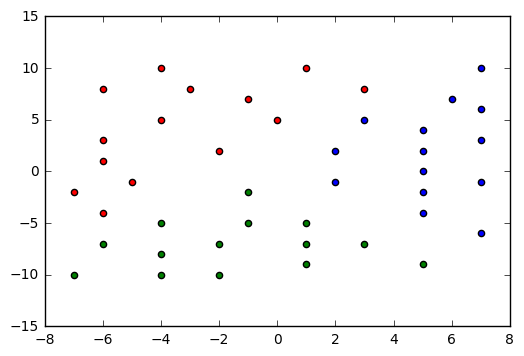

In [19]:
# Plot dataset
plt.scatter(data[:14,0], data[:14,1], c='r')
plt.scatter(data[14:28,0], data[14:28,1], c='g')
plt.scatter(data[28:,0], data[28:,1], c='b')

In [20]:
# Run SVM
C = 10
learning_rate = 0.003
batch_size = 2800 # Just some really big number to mean "the entire dataset in one batch"
epochs = 1000
ws = multiclass_train_loop(data, labels, data, labels, C, learning_rate, batch_size, epochs)
print ws

[[-0.54975171 -0.06136595  0.39465926]
 [ 0.42182046 -0.29361379  0.06494681]
 [-0.7268056  -0.87686927 -0.86309866]]


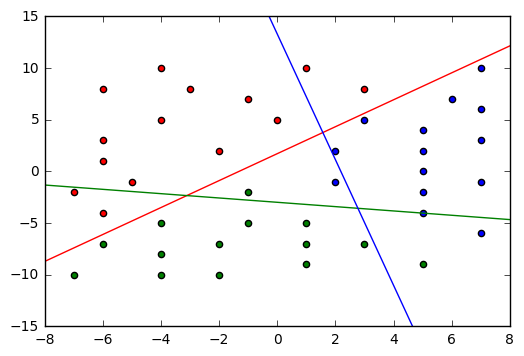

In [21]:
# Visualize results
# Dots are correctly classifier, crosses are incorrectly classifier
# Coloured lines are decision boundaries for each classifier
predictions = get_multiclass_predictions(data, ws)
actual = np.argmax(labels, axis=1)
correct = np.equal(predictions, actual)

mask = np.logical_and(correct, np.equal(actual, 0))
plt.scatter(data[mask, 0], data[mask,1], c='r')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 0))
plt.scatter(data[mask, 0], data[mask,1], c='r', marker='+')

mask = np.logical_and(correct, np.equal(actual, 1))
plt.scatter(data[mask, 0], data[mask,1], c='g')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 1))
plt.scatter(data[mask, 0], data[mask,1], c='g', marker='+')

mask = np.logical_and(correct, np.equal(actual, 2))
plt.scatter(data[mask, 0], data[mask,1], c='b')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 2))
plt.scatter(data[mask, 0], data[mask,1], c='b', marker='+')

plt.axis((-8, 8, -15, 15))

a, b, c = ws[:, 0]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='r')

a, b, c = ws[:, 1]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='g')

a, b, c = ws[:, 2]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='b')

# Apply SVM to HOG Features

In [29]:
# Run SVM
C = 10
learning_rate = 0.001
batch_size = 200
epochs = 25
ws = multiclass_train_loop(train['hog_features'], train['labels'],
                           test['hog_features'], test['labels'],
                           C, learning_rate, batch_size, epochs)
print ws
predictions = get_multiclass_predictions(test['hog_features'], ws)
labels = test['labels']
actual = np.argmax(labels, axis=1)
correct = np.equal(predictions, actual)
accuracy = np.mean(correct.astype('float32'))
print "Final accuracy:", accuracy

Starting label 0
Epoch 0, step 0, training loss 174.412902, test loss 177.898645
Epoch 0, step 50, training loss 157.915104, test loss 159.838357
Epoch 0, step 100, training loss 141.991325, test loss 144.461003
Epoch 0, step 150, training loss 127.531256, test loss 131.125446
Epoch 0, step 200, training loss 116.936658, test loss 119.166876
Epoch 0, step 250, training loss 106.366599, test loss 108.390332
End of epoch 299, training loss 97.057629, test loss 98.879617
Epoch 1, step 0, training loss 96.580364, test loss 98.694943
Epoch 1, step 50, training loss 88.069345, test loss 89.930849
Epoch 1, step 100, training loss 79.980820, test loss 81.990362
Epoch 1, step 150, training loss 71.735821, test loss 74.854158
Epoch 1, step 200, training loss 66.279818, test loss 68.348656
Epoch 1, step 250, training loss 60.555914, test loss 62.457983
End of epoch 299, training loss 55.325791, test loss 57.260700
Epoch 2, step 0, training loss 55.050228, test loss 57.160673
Epoch 2, step 50, tra